# A domain wall causes large norm error and incorrect energies
By Tomohiro Soejima

In this notebook, we look at the effect of a domain wall on iDMRG algorithm. We will see a domain wall can result in non-translation invariant ground state, large norm error, and incorrect enery reporting by DMRG.

We consider the following XXZ Hamiltonian from [`tenpy.models.xxz_chain.XXZChain`](https://tenpy.readthedocs.io/en/latest/reference/tenpy.models.xxz_chain.XXZChain.html#tenpy.models.xxz_chain.XXZChain).

$$ H = \sum_i \frac{\mathtt{Jxx}}{2} (S^{+}_i S^{-}_{i+1} + S^{-}_i S^{+}_{i+1})
                 + \mathtt{Jz} S^z_i S^z_{i+1} $$
                 
When $\mathtt{Jz} > 0$ and $ |\mathtt{Jxx}| << |\mathtt{Jz}| $, the translation invariant ground states look like

$$
\begin{aligned}
& \ldots \uparrow \uparrow \uparrow \ldots \\
& \ldots \downarrow \downarrow\downarrow \ldots 
\end{aligned}
$$
with some perturbation on top of it.

These are however not the only ground states! There are _infinitely many_ translation breaking ground states with a single domain wall.

$$
\ldots \uparrow \uparrow \uparrow \downarrow \downarrow\downarrow \ldots
$$

(One might object these states have higher energy than fully-polarized ground states. These states are ground states due to a unique feature of infinite-size sytems: A given quantum state is a ground state if there is no _local_ perturbation that can lower its energy. Since we can not remove a single domain wall locally, these states are ground states.)

Which set of ground states does DMRG find? It depends on how DMRG is initialized. Consider the example of two-site DMRG (implemented in [`tenpy.algorithms.dmrg.TwoSiteDMRGEngine`](https://tenpy.readthedocs.io/en/latest/reference/tenpy.algorithms.dmrg.TwoSiteDMRGEngine.html#tenpy.algorithms.dmrg.TwoSiteDMRGEngine). There are two choices for initial product states.

1. [$\uparrow, \uparrow$] or [$\downarrow, \downarrow$]
2. [$\uparrow, \downarrow$] or [$\downarrow, \uparrow$]

The first choice lead to spin-polarized ground states. Let's consider what happens to the second choice. In DMRG, we first initialize left and right environments, such that our state will look something like

$$ \uparrow \downarrow \uparrow \downarrow \uparrow \downarrow \uparrow \downarrow [\uparrow \downarrow] \uparrow \downarrow\uparrow \downarrow\uparrow \downarrow \uparrow \downarrow, $$

where $[\uparrow \downarrow]$ represent the location to be optimized, and repeated $\uparrow\downarrow$ correspond to the environment. What is the lowest energy state we can write down while fixing the environments? Noting that iDMRG algorithm often conserve symmetries (either implicitly or explicitly via [`np_conserved`](https://tenpy.readthedocs.io/en/latest/reference/tenpy.linalg.np_conserved.html)), we need to answer this question with $S_z$ conservation. The lowest energy state is then

$$ \uparrow \downarrow \uparrow \downarrow \uparrow \downarrow \uparrow \downarrow [\downarrow \uparrow] \uparrow \downarrow\uparrow \downarrow\uparrow \downarrow \uparrow \downarrow, $$

which minimizes the number of domain walls. Then, the state $[\downarrow, \uparrow]$ is used to grown the environments by one site to give us the next iteration:

$$ \uparrow \downarrow \uparrow \downarrow \uparrow \downarrow \uparrow \downarrow \downarrow [\uparrow, \downarrow] \uparrow \uparrow \downarrow\uparrow \downarrow\uparrow \downarrow \uparrow \downarrow. $$

By repeating this iteration, we see that our iDMRG will converge to

$$\uparrow \downarrow \uparrow \downarrow \uparrow \downarrow \uparrow \downarrow \downarrow\ldots\downarrow\downarrow \uparrow \uparrow \uparrow \ldots \uparrow \uparrow  \downarrow\uparrow \downarrow\uparrow \downarrow \uparrow \downarrow
$$

Since what is happening at the edge does not matter for the nature of the ground state, we conclude that iDMRG converged to a translation breaking ground state with a single domain wall.

## Detecting a domain wall: E_DMRG v. E_MPO
iDMRG algorithm _assumes_ that we converge to a translation invariant ground state. As a result, there are many ways our usual intuition for iDMRG can break down in the presence of a domain wall. We can use those to detect the presence of a domain wall.

The first test we look at is the energy difference between
1. `E_DMRG`: The energy reported by iDMRG algorithm. (returned by [`DMRGengine.run()`](https://tenpy.readthedocs.io/en/latest/reference/tenpy.algorithms.dmrg.DMRGEngine.html#tenpy.algorithms.dmrg.DMRGEngine.run) for example.)
2. `E_MPO` : The energy computed from iMPS and iMPO. (Can be evaluated by [`MPO.expectation_value(psi)`](https://tenpy.readthedocs.io/en/latest/reference/tenpy.networks.mpo.MPO.html#tenpy.networks.mpo.MPO.expectation_value))

The former is defined as follows. During iDMRG iteration, we grow our systems size by two lattice sites per iteration. We compute the energy of the entire system at each iteration, which we call `E_sweep[i]`. Then `E_DMRG = E_sweep[N_sweeps] - E_sweep[N_sweeps-1]` serves as a good approximation for the energy per two lattice sites.

On the other hand, `E_MPO` is obtained by first converting the result of iDMRG to an iMPS, and then evaluting its energy with respect to the Hamiltonian represented by an MPO.

In the ferromagnetic case, the `E_DMRG` and `E_MPO` are expected to coincide. The energy to grow the system by two unit cells $\ldots \uparrow \uparrow \ldots \to \ldots \uparrow \uparrow \uparrow \uparrow \ldots $ should be `2 * Jz / 4`, which is the same as the energy per unit cell.

Let's now consider the case with a domain wall. When we add two sites $\ldots \uparrow \downarrow \ldots \to \ldots \uparrow \uparrow \downarrow \downarrow \ldots $, the energy again changes by `2 * Jz/4`. However, the iMPS extracted from the final state of DMRG will be $\ldots \uparrow \downarrow \uparrow \downarrow \uparrow \downarrow \uparrow \downarrow \ldots$. The energy per unit cell is `-2 * Jz/4`, which is different from `E_DMRG`!

We can now test this prediction using iDMRG.

In [1]:
import numpy as np
import tenpy
import time
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.models.xxz_chain import XXZChain
from tenpy.algorithms import dmrg

def dmrg_XXZchain(Jxx, Jz, chi=10, ps = ["up", "down"]):
    # two site unit cell
    model_params = dict(L=2, Jxx=Jxx, Jz = Jz, bc_MPS='infinite')
    M = XXZChain(model_params)
    # create initial state
    product_state = ps * (M.lat.N_sites//2)
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'start_env': 10,
        'mixer': False,
        #  'mixer_params': {'amplitude': 1.e-3, 'decay': 5., 'disable_after': 50},
        'trunc_params': {
            'chi_max': 5,
            'svd_min': 1.e-10
        },
        'max_E_err': 1.e-9,
        'max_S_err': 1.e-6,
        'update_env': 0,
    }
    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    eng.trunc_params['chi_max'] = chi
    ##   DMRG Calculation    ##
    E_DMRG, psi = eng.run()
    E_MPO = M.H_MPO.expectation_value(psi)
    ## Compute Sz expecation values ##
    Sz = psi.expectation_value("Sz")
    ## Norm error ##
    norm_err = psi.norm_test()
    return psi, E_DMRG, E_MPO, Sz, norm_err

In [7]:
print("|Jz | ps | `E_DMRG` | `E_MPO` | S_z |")
print("|--- | --- | --- | --- | --- |")
for Jz in [-1, 1]:
    for ps in [["up", "down"], ["up", "up"]]:
        psi, E_DMRG, E_MPO, Sz, norm_err = dmrg_XXZchain(Jxx=0.0, Jz=Jz, chi=10, ps=ps)
        print(f"|{Jz}|{ps}|{E_reported}|{E_MPO}|{Sz}|")

|Jz | ps | `E_DMRG` | `E_MPO` | S_z |
|--- | --- | --- | --- | --- |
|-1|['up', 'down']|0.25|0.25|[ 0.5 -0.5]|
|-1|['up', 'up']|0.25|-0.25|[0.5 0.5]|
|1|['up', 'down']|0.25|-0.25|[ 0.5 -0.5]|
|1|['up', 'up']|0.25|0.25|[0.5 0.5]|


|Jz | ps | `E_DMRG` | `E_MPO` | S_z |
|--- | --- | --- | --- | --- |
|-1|['up', 'down']|-0.25|0.25|[ 0.5 -0.5]|
|-1|['up', 'up']|-0.25|-0.25|[0.5 0.5]|
|1|['up', 'down']|-0.25|-0.25|[ 0.5 -0.5]|
|1|['up', 'up']|0.25|0.25|[0.5 0.5]|

In the computation above, we set `Jxx=0`, and varies the initial state `ps`, `Jz`, and measured `E_DMRG`, `E_MPO` and also `Sz` expectation values. We see that when `Jz=-1` (i.e. ferromagnetic) and `ps=["up", "down"]`, `E_MPO` and `E_DMRG` has the opposite sign, exactly as expected! This signals that `["up", "down"]` initial state leads to non-translation-invariant final state in iDMRG.

## Detecting domain wall from norm error

There is another manifestation of a domain wall, which manifest in non-vanishing [`norm_error`](https://tenpy.readthedocs.io/en/latest/reference/tenpy.networks.mps.MPS.html#tenpy.networks.mps.MPS.norm_test).

`norm_error` is computed by comparing the following two diagrams:

```
|   --theta[i]---.       --s[i]--.
|       |        |    vs         |
|   --theta*[i]--.       --s[i]--.
```

`norm_error` goes to zero if iDMRG converges to a translation invariant state. However, if it converges to a state with a domain wall, `norm_error` does not go to zero.

To see this, notice that `--s--s--` diagram is computed from the SVD of the previous step, so it captures the entanglement exactly at the domain wall (red vertical line), while `--theta--theta--` captures the entanglement at the green vertical line, which captures entanglement slightly away from domain wall.

$$
\ldots \uparrow \uparrow \color{green}{|}[\uparrow \color{red}{|} \downarrow] \downarrow \downarrow \ldots
$$

These two cuts don't need to have the same entanglement, and it can result in nonzero `norm_error`.

In the following, we will see this for a concrete example of XXZ chain. We will set `Jxx != 0` so that ground states are not product states.

In [ ]:
print("|Jz | ps | `E_DMRG` | `E_MPO` | S_z |")
print("|--- | --- | --- | --- | --- |")
for Jz in [-1, 1]:
    for ps in [["up", "down"], ["up", "up"]]:
        psi, E_DMRG, E_MPO, Sz, norm_err = dmrg_XXZchain(Jxx=0.2, Jz=Jz, chi=10, ps=ps)
        print(f"|{Jz}|{ps}|{E_DMRG}|{E_MPO}|{Sz}|")

Jxx = 0.2

|Jz | ps | `E_DMRG` | `E_MPO` | S_z |
|--- | --- | --- | --- | --- |
|-1|['up', 'down']|-0.2499999999999991|0.2349979690226362|[ 0.48989693 -0.48989693]|
|-1|['up', 'up']|-0.25|-0.25|[0.5 0.5]|
|1|['up', 'down']|-0.2599000101934674|-0.2599000101934509|[ 0.47979802 -0.47979802]|
|1|['up', 'up']|0.25|0.25|[0.5 0.5]|

We can already notice a long warning sign about nonzero `norm_error`. We also observe `E_DMRG != E_MPO` as expected.

We can plot norm_error as a function of `Jxx`, which sets the degree of entanglement.

In [3]:
Jz = -1
ps = ["up", "down"]
for Jxx in np.linspace(0, 1, 11):
    psi, E_DMRG, E_MPO, Sz, norm_err = dmrg_XXZchain(Jxx=Jxx, Jz=Jz, chi=10, ps=ps)

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=5.03e-03
norm_err=5.03e-03 still too high after environment_sweeps
final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=5.03e-03, calling psi.canonical_form()
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=2.04e-02
norm_err=2.04e-02 still too high after environment_sweeps
final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=2.04e-02, calling psi.canonical_form()
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
canonical_form_infinite: project to significantly smaller chi
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=4.71e-02
norm_err=4.71e-02 still too high after environment_sweeps
final DMRG state not in canonical 

<function matplotlib.pyplot.show(close=None, block=None)>

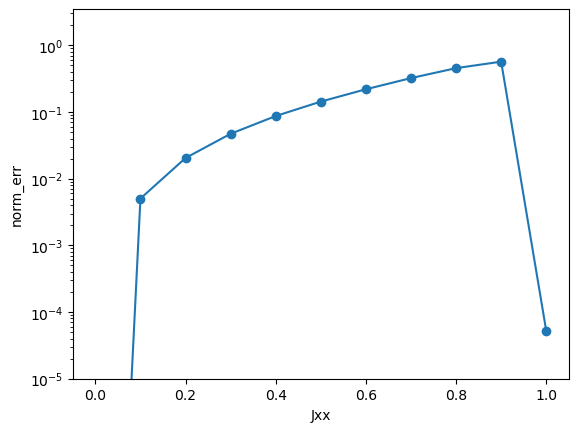

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

norm_errs = [1e-16, 5.03e-03, 2.04e-02, 4.71e-02, 8.69e-02, 1.43e-01, 2.19e-01, 3.22e-01, 4.54e-01, 5.68e-01, 5.21e-05]
plt.plot(np.linspace(0, 1, 11), norm_errs, "o-")
plt.yscale("log")
plt.xlabel("Jxx")
plt.ylabel("norm_err")
plt.ylim(ymin = 1e-5)
plt.show

We see norm error steadily increases until it goes back down again at Jxx = 1. If we turn on logging, we can see these large norm errors aren't due to lack of sweeps:

In [19]:
import logging
logging.basicConfig(level=logging.INFO)

Jz = -1
Jxx = 0.2
ps = ["up", "down"]
psi, E_DMRG, E_MPO, Sz, norm_err = dmrg_XXZchain(Jxx=Jxx, Jz=Jz, chi=10, ps=ps)

INFO:tenpy.tools.params:XXZChain: reading 'L'=2
INFO:tenpy.tools.params:XXZChain: reading 'Jxx'=0.2
INFO:tenpy.tools.params:XXZChain: reading 'Jz'=-1
INFO:tenpy.tools.params:XXZChain: reading 'bc_MPS'='infinite'
INFO:tenpy.tools.params:TwoSiteDMRGEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'start_env'=10
INFO:tenpy.algorithms.mps_common:start environment_sweep
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=5
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-10
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'max_E_err'=1e-09
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'max_S_err'=1e-06
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'update_env'=0
INFO:tenpy.tools.params:TwoSiteDMRGEngine: reading 'mixer'=False
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
INFO:tenpy.algorithms.dmrg:checkpoint after sweep 10
energy=-0.2500000000000003, max S=0.0574181342308985, age=16

We see that both Delta E and Delta S are exteremely small, showing good convergence, but `norm_err` stays high around 2.0e-2. We can also observe its dependence on `Jxx`, which sets the states deviation from a product state.

## Conclusion

When we run iDMRG, the state can converge to a translation-breaking state with a domain wall. When this happens, many things about iDMRG fails. Most notably, there will be two clear signs of failure:

1. `E_MPO` and `E_DMRG` will not agree with each other.
2. `norm_error` does not go to zero.

When these kind of behaviors show up, suspect the presence of a domain wall!